In [1]:
!pip install -r requirements.txt

    100% |████████████████████████████████| 81kB 3.8MB/s ta 0:00:01    28% |█████████                       | 20kB 10.9MB/s eta 0:00:01
    100% |████████████████████████████████| 60.7MB 268kB/s ta 0:00:011  0% |▏                               | 337kB 7.5MB/s eta 0:00:09    3% |█                               | 1.9MB 11.2MB/s eta 0:00:06    4% |█▎                              | 2.4MB 11.7MB/s eta 0:00:05    8% |██▋                             | 4.9MB 11.0MB/s eta 0:00:06    8% |██▉                             | 5.4MB 11.1MB/s eta 0:00:05    9% |███                             | 5.9MB 10.1MB/s eta 0:00:06    10% |███▎                            | 6.3MB 11.2MB/s eta 0:00:05    11% |███▊                            | 7.2MB 12.5MB/s eta 0:00:05    12% |████                            | 7.5MB 11.3MB/s eta 0:00:05    14% |████▌                           | 8.5MB 11.3MB/s eta 0:00:05    14% |████▊                           | 8.9MB 6.7MB/s eta 0:00:08    17% |█████▋                          | 10

In [2]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque
from workspace_utils import active_session
from agent import Agent
from unityagents import UnityEnvironment

In [3]:
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


In [7]:
agent = Agent(state_size, action_size, random_seed=0,agents=2)

In [8]:
def maddpg(n_episodes=2000, print_every=10, score_solved=0.5):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    
    agent_score = []                        # list containing scores for each episode
    scores_window = deque(maxlen=100)       # last 100 scores
    
    for i_episode in range(1, n_episodes+1):

        env_info = env.reset(train_mode=True)[brain_name]      # reset environment
        states = env_info.vector_observations                 # get current state for each agent      
        scores = np.zeros(num_agents)                            # initialize score for each agent
        agent.reset()                                       
        
        while True:
            actions = agent.act(states)                        # select an action
            env_info = env.step(actions)[brain_name]           # send actions to environment
            next_states = env_info.vector_observations         # get next state
            rewards = env_info.rewards                         # get reward
            dones = env_info.local_done                        # see if episode has finished
            
            # save experience to replay buffer, perform learning step at defined interval
            agent.step(states, actions, rewards, next_states, dones)
            
            states = next_states
            scores += rewards                                          
            
            if np.any(dones):                               # exit loop if episode finished
                break          
        
        score = np.max(scores)
        scores_window.append(score)
        agent_score.append(score)
        
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)), end="")
                
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= score_solved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.actor_local.state_dict(), 'actor_checkpoint.pth')
            torch.save(agent.critic_local.state_dict(), 'critic_checkpoint.pth')
            break
            
    return agent_score


In [9]:
with active_session():
    scores = maddpg()

Episode 10	Average Score: 0.0200
Episode 20	Average Score: 0.0100
Episode 30	Average Score: 0.0067
Episode 40	Average Score: 0.0120
Episode 50	Average Score: 0.0234
Episode 60	Average Score: 0.0245
Episode 70	Average Score: 0.0307
Episode 80	Average Score: 0.0355
Episode 90	Average Score: 0.0401
Episode 100	Average Score: 0.0418
Episode 110	Average Score: 0.0448
Episode 120	Average Score: 0.0537
Episode 130	Average Score: 0.0616
Episode 140	Average Score: 0.0686
Episode 150	Average Score: 0.0795
Episode 160	Average Score: 0.0915
Episode 170	Average Score: 0.1177
Episode 180	Average Score: 0.1208
Episode 190	Average Score: 0.1311
Episode 200	Average Score: 0.1484
Episode 210	Average Score: 0.1712
Episode 220	Average Score: 0.1852
Episode 230	Average Score: 0.2183
Episode 240	Average Score: 0.2365
Episode 250	Average Score: 0.2366
Episode 260	Average Score: 0.2445
Episode 270	Average Score: 0.2374
Episode 280	Average Score: 0.2604
Episode 290	Average Score: 0.2564
Episode 300	Average Sco

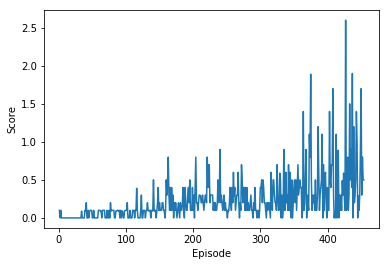

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

In [11]:
env.close()